##Train Model

In [0]:
import os
import random
import glob
import numpy as np
import pandas as pd
import torch
import csv
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary


def load_data(img_path, label_path):
    train_image = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
    train_label = pd.read_csv(label_path)
    train_label = train_label.iloc[:,1].values.tolist()
    
    train_data = list(zip(train_image, train_label))
    
    random.shuffle(train_data)
    
    
    train_set = train_data[:200]
    valid_set = train_data[200:]
    
    return train_set, valid_set
    
    #return train_data
    
class hw3_dataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transform(img)
        label = self.data[idx][1]
        return img, label

class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])
        self.fc = nn.Linear(512,7)
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, 1*1*512)
        x = self.fc(x)
        
        return x

def show_train_history(train, validation, name):
  plt.plot(train)
  plt.plot(validation)
  plt.title(name)
  plt.ylabel('train')
  plt.xlabel('Epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


#summary(model, input_size=(3, 48, 48))

Epoch: 1, train Loss: 2.6784, train Acc: 0.1380
model saved to model_1.pth
Epoch: 1, valid Loss: 2.9147, valid Acc: 0.1875
Epoch: 2, train Loss: 0.9234, train Acc: 0.7170
model saved to model_2.pth
Epoch: 2, valid Loss: 3.0541, valid Acc: 0.2000
Epoch: 3, train Loss: 0.3323, train Acc: 0.9349
model saved to model_3.pth
Epoch: 3, valid Loss: 3.1485, valid Acc: 0.2125
Epoch: 4, train Loss: 0.1613, train Acc: 0.9527
model saved to model_4.pth
Epoch: 4, valid Loss: 2.7260, valid Acc: 0.3125
Epoch: 5, train Loss: 0.0567, train Acc: 0.9891
model saved to model_5.pth
Epoch: 5, valid Loss: 2.2920, valid Acc: 0.3875
Epoch: 6, train Loss: 0.0879, train Acc: 0.9891
Epoch: 6, valid Loss: 2.2091, valid Acc: 0.4000
Epoch: 7, train Loss: 0.0368, train Acc: 0.9861
Epoch: 7, valid Loss: 2.0340, valid Acc: 0.4375
Epoch: 8, train Loss: 0.0323, train Acc: 0.9852
Epoch: 8, valid Loss: 1.8818, valid Acc: 0.4875
Epoch: 9, train Loss: 0.1406, train Acc: 0.9822
Epoch: 9, valid Loss: 1.7508, valid Acc: 0.5125
E

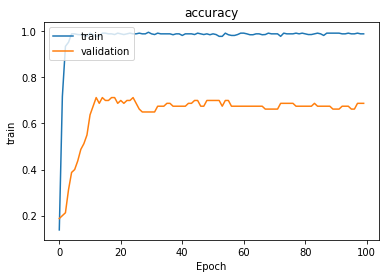

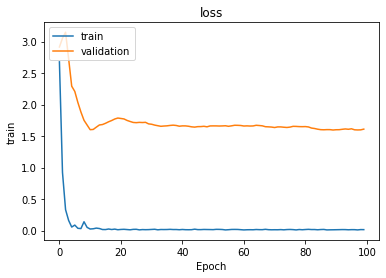

In [0]:
if __name__ == '__main__':
    use_gpu = torch.cuda.is_available()

    Base_dir = 'data/'
    train_set, valid_set = load_data(Base_dir+'sample_dataset', Base_dir+'sample_response.csv')
    #train_set = load_data(Base_dir+'sample_dataset', Base_dir+'sample_response.csv')
    #transform to tensor, data augmentation
    
    transform = transforms.Compose([
    #transforms.RandomAffine(15, translate=(0.1,0.1), scale=(0.9,1.1), shear=10, fillcolor=0),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize([mean], [std], inplace=False)
    ])
    
    train_dataset = hw3_dataset(train_set,transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    #valid_dataset = hw3_dataset(valid_set,transform)
    #valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
    

    model = Resnet18()
    if use_gpu:
        model.cuda()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    train_his_acc = []
    train_his_loss = []
    valid_his_acc = []
    valid_his_loss = []
    best_acc = 0
    num_epoch = 100
    for epoch in range(num_epoch):
        model.train()
        train_loss = []
        train_acc = []
        for idx, (img, label) in enumerate(train_loader):
            if use_gpu:
                img = img.cuda()
                label = label.cuda()
            optimizer.zero_grad()
            output = model(img)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            predict = torch.max(output, 1)[1]
            acc = np.mean((label == predict).cpu().numpy())
            train_acc.append(acc)
            train_loss.append(loss.item())
        print("Epoch: {}, train Loss: {:.4f}, train Acc: {:.4f}".format(epoch + 1, np.mean(train_loss), np.mean(train_acc)))
        acc = np.mean(train_acc)
        if acc > best_acc:
          best_acc = acc
          checkpoint_path = 'model_{}.pth'.format(epoch+1) 
          torch.save(model.state_dict(), checkpoint_path)
          print('model saved to %s' % checkpoint_path)
        train_his_acc.append(acc)
        train_his_loss.append(np.mean(train_loss))
        
      
        model.eval()
        with torch.no_grad():
            valid_loss = []
            valid_acc = []
            for idx, (img, label) in enumerate(valid_loader):
                if use_gpu:
                    img = img.cuda()
                    label = label.cuda()
                output = model(img)
                loss = loss_fn(output, label)
                predict = torch.max(output, 1)[1]
                acc = np.mean((label == predict).cpu().numpy())
                valid_loss.append(loss.item())
                valid_acc.append(acc)
            print("Epoch: {}, valid Loss: {:.4f}, valid Acc: {:.4f}".format(epoch + 1, np.mean(valid_loss), np.mean(valid_acc)))
            valid_his_acc.append(np.mean(valid_acc))
            valid_his_loss.append(np.mean(valid_loss))
        
    
    
    show_train_history(train_his_acc, valid_his_acc, "accuracy")
    show_train_history(train_his_loss, valid_his_loss, "loss")
    
    #finish test code


##Get Testing Data
1.   Prediction

1.   Get comparison of different weights




In [0]:
from PIL import Image, ImageDraw
import face_recognition

Base_dir = 'data/'

class hw3_Testdataset(Dataset):
    
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('RGB')
        img = self.transform(img)
        return img

def loadtest(test_path, model_path):

  transform = transforms.Compose([transforms.ToTensor()])

  test_img = sorted(glob.glob(os.path.join(test_path, '*.jpg')))
  test_dataset = hw3_Testdataset(test_img,transform)
  test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

  model = Resnet18()
  model.load_state_dict(torch.load(model_path))
  device = torch.device('cuda')
  model = model.to(device)
  model.eval()
  
  prediction = []
  with torch.no_grad():
    for img in test_loader:
      img = img.to(device)
      out = model(img)
      _, pred_label = torch.max(out, 1)
      for i in range(pred_label.size(0)):
        prediction.append(pred_label[i].item())
  
  df = pd.DataFrame({'id': np.arange(0,len(prediction)), 'label': prediction})
  df.to_csv(Base_dir+'prediction_1.csv',index=False)
  return prediction

def getLandmark(test_path):
  
  lands = []
  test_img = sorted(glob.glob(os.path.join(test_path, '*.jpg')))

  for i, name in enumerate(test_img):

  # Load the jpg file into a numpy array
    image = face_recognition.load_image_file(name)

    # Find all facial features in all the faces in the image
    face_landmarks_list = face_recognition.face_landmarks(image)

    #Create a white image to show landmark only
    landmark_img = Image.new('RGB', (48,48), (255,255,255,0))
    pure_d = ImageDraw.Draw(landmark_img)

    for face_landmarks in face_landmarks_list:

        for facial_feature in face_landmarks.keys():
            pure_d.line(face_landmarks[facial_feature], width=1, fill='black')

    landmark_img.save(Base_dir+'Test_landmark/landmark_{}.jpg'.format(i))
    print('{} landmark file number saved'.format(i))
    
    land = np.zeros(1)
    for val in face_landmarks.values():
      nVal = np.array(val).flatten()
      land = np.append(land, nVal)
    land = np.delete(land,0)
    lands.append(land)

  lands = np.array(lands)
  np.save(Base_dir+'Test_landmarks.npy', lands)
  print('Test landmarks shape: ',lands.shape)
  
  return lands

def mixLandmark(emo, ori):
  
  response = np.genfromtxt(Base_dir+'prediction_1.csv', delimiter=',', dtype=int, skip_header=1)[:,1]
  test_land = np.load(Base_dir+'Test_landmarks.npy')
  basic_land = np.load(Base_dir+'basic_landmark/Basic_landmarks.npy')
  print('basic_land shape: ' , basic_land.shape)
  
  emotion_land = np.zeros((1,144))
  for res in response:
    emotion_land = np.concatenate((emotion_land, basic_land[res].reshape((1,144))))
  emotion_land = np.delete(emotion_land, 0, 0)
  print('emotion landmarks shape: ', emotion_land.shape) # suppose to be (21,144)

  # get the mean landmark
  print('test landmarks shape: ', test_land.shape)
  mix_land = np.around(emotion_land*emo + test_land*ori)
  mix_land = np.array(mix_land, dtype=int)

  # Output the Image
  lines = [17, 5, 5, 4, 5, 6, 6, 12, 12]

  ret = []
  for idx in range(21):

    landmark_img = Image.new('RGB', (48,48), (255,255,255,0))
    pure_d = ImageDraw.Draw(landmark_img)


    base = 0
    for dotnum in lines:
      mark = []
      for k in range(dotnum):
        ptr = base + k*2
        point = (mix_land[idx][ptr], mix_land[idx][ptr+1])
        mark.append(point)
      pure_d.line(mark, width=1, fill='black')
      base += dotnum*2

    #landmark_img.save(Base_dir+'response_basic/result_{}.jpg'.format(idx))

    # show in combo (origin_image, landmark)
    #im1 = Image.open(Base_dir+'Testdata/{}.jpg'.format(str(idx).zfill(2))).convert('RGB')
    #im2 = landmark_img
    #combo = Image.fromarray(np.hstack((np.array(im1),np.array(im2))))
    #combo.show()
    #combo.save(Base_dir+'result_landmark/result_landmark_{}.jpg'.format(idx))

    # show in compare with different ratio
    ret.append(landmark_img)

  return ret


#response = loadtest(Base_dir+'Testdata', 'model_30.pth')
#Test_landmark = getLandmark(Base_dir+'Testdata')
mixLandmark(0.8,0.2)

basic_land shape:  (7, 144)
emotion landmarks shape:  (21, 144)
test landmarks shape:  (21, 144)


In [0]:
ret1 = mixLandmark(0.6, 0.4)
ret2 = mixLandmark(0.8, 0.2)

for i in range(21):
    im1 = Image.open(Base_dir+'Testdata/{}.jpg'.format(str(i).zfill(2))).convert('RGB')
    im2 = ret1[i]
    im3 = ret2[i]
    images = [im1, im2, im3]
    
    total_width = 48*3
    max_height = 48

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save(Base_dir+'method1_img2response/comp/result_{}.jpg'.format(i))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install face_recognition